<font color = "purple"><h2><b><center> POS tagging using modified Viterbi </center></b></h2></font>

In [1]:
#Importing libraries

import nltk
import re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import random
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split


<font color = "green"><h3><b> Reading the Treebank tagged sentences </b></h3></font>

In [49]:
test_file_path = r'E:\Upgrad\NLP\Assignment\Test_sentences.txt'

In [2]:
# reading the Treebank tagged sentences
# nltk.download('universal_tagset')
treebank_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
print(treebank_data[0])

[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]


<font color = "green"><h3><b> Data Preparation </b></h3></font>

In [3]:
# Splitting Treebank tagged set into train and test

random.seed(1000)
train_set, test_set = train_test_split(treebank_data, test_size=0.05)

print("Training Set Length: ", len(train_set))
print("Training Set Length: ", len(test_set))
print("=" * 127)
print("Training Data Glimpse: \r\n")
print(train_set[0])
print("")
print(train_set[1])

Training Set Length:  3718
Training Set Length:  196
Training Data Glimpse: 

[('In', 'ADP'), ('part', 'NOUN'), (',', '.'), ('this', 'DET'), ('may', 'VERB'), ('reflect', 'VERB'), ('the', 'DET'), ('fact', 'NOUN'), ('that', 'ADP'), ('`', '.'), ('she', 'PRON'), ('speaks', 'VERB'), ('a', 'DET'), ('more', 'ADJ'), ('progressive', 'ADJ'), ('language', 'NOUN'), ("'", '.'), ('than', 'ADP'), ('her', 'PRON'), ('husband', 'NOUN'), ('*?*', 'X'), (',', '.'), ('as', 'ADP'), ('Columbia', 'NOUN'), ("'s", 'PRT'), ('Prof', 'NOUN'), ('.', '.'), ('-LCB-', '.'), ('Ethel', 'NOUN'), ('-RCB-', '.'), ('Klein', 'NOUN'), ('puts', 'VERB'), ('it', 'PRON'), ('.', '.')]

[('LANDOR', 'NOUN'), ('ASSOCIATES', 'NOUN'), (':', '.')]


In [4]:
# Getting list of tagged words

train_set_tagged_words = [tup for sent in train_set for tup in sent]
print("Total tagged words: ", len(train_set_tagged_words))

Total tagged words:  95760


In [5]:
# Retrieve words and POS

words = []
POS = []

for items in train_set_tagged_words:
    words.append(items[0])
    POS.append(items[1])


In [6]:
train_unique_words = set(words)
train_unique_POS = set(POS)

total_words = len(train_unique_words)
total_POS = len(train_unique_POS)

print("Total unique words: ", total_words)
print("Total unique POS: ", total_POS)

Total unique words:  12086
Total unique POS:  12


<font color = "green"><h3><b> Emission and Transition Probabilities </b></h3></font>

In [7]:
# compute word given tag: Emission Probability

def word_given_tag(word, tag, train_bag = train_set_tagged_words):
    
    count_tag = 0
    count_w_given_tag = 0
    
    for pair in train_bag:
        
        if pair[1]==tag:
            count_tag += 1
            
            if pair[0]==word:
                count_w_given_tag += 1
    
    return (count_w_given_tag, count_tag)

In [8]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_set_tagged_words):

    index = 0
    count_t1 = 0
    count_t2_t1 = 0
    previous_tag = ''
    
    for pair in train_bag:
        
        current_tag = pair[1]
        
        if current_tag == t1:
            count_t1 += 1
            
        if current_tag == t2 and previous_tag == t1:
            count_t2_t1 += 1
        
        previous_tag = current_tag
        
    return (count_t2_t1, count_t1)

In [9]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((total_POS, total_POS), dtype='float32')
for i, t1 in enumerate(list(train_unique_POS)):
    for j, t2 in enumerate(list(train_unique_POS)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

# convert the matrix to a data frame for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(train_unique_POS), index=list(train_unique_POS))

# dataset glimpse
tags_df

,PRON,NUM,X,DET,CONJ,NOUN,VERB,PRT,.,ADJ,ADV,ADP
PRON,0.007316,0.007316,0.093955,0.009626,0.005006,0.206007,0.485560,0.013092,0.040431,0.073931,0.034655,0.023104
NUM,0.001492,0.184069,0.211814,0.002685,0.014320,0.348449,0.018795,0.028043,0.119332,0.033115,0.002685,0.035203
X,0.055723,0.002858,0.074933,0.054929,0.010478,0.061756,0.202572,0.185426,0.164629,0.017146,0.026195,0.143356
DET,0.003739,0.021828,0.043777,0.005548,0.000482,0.640376,0.039797,0.000241,0.017969,0.204414,0.012663,0.009165
CONJ,0.058770,0.041781,0.007805,0.118457,0.000459,0.350321,0.155188,0.005051,0.035354,0.118457,0.055096,0.053260
NOUN,0.004885,0.009333,0.029421,0.013125,0.043166,0.264173,0.147800,0.043531,0.239637,0.012104,0.016989,0.175836
VERB,0.035247,0.022775,0.218065,0.134712,0.005423,0.109846,0.169417,0.030909,0.034859,0.065303,0.081803,0.091641
PRT,0.017332,0.058208,0.013734,0.098757,0.001962,0.246893,0.402878,0.001635,0.043165,0.084369,0.010137,0.020929
.,0.065609,0.080308,0.027068,0.172717,0.058618,0.222730,0.087748,0.002510,0.094111,0.044456,0.053061,0.090974
ADJ,0.000655,0.020963,0.020963,0.004913,0.016869,0.697019,0.012119,0.011300,0.064854,0.067147,0.004913,0.078284


<font color = "green"><h3><b> Exploratory Data Analysis </b></h3></font>

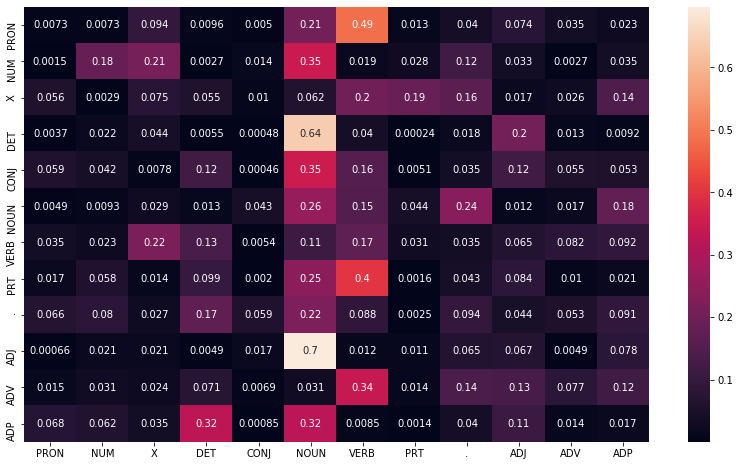

In [10]:
# heatmap of tags matrix

plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

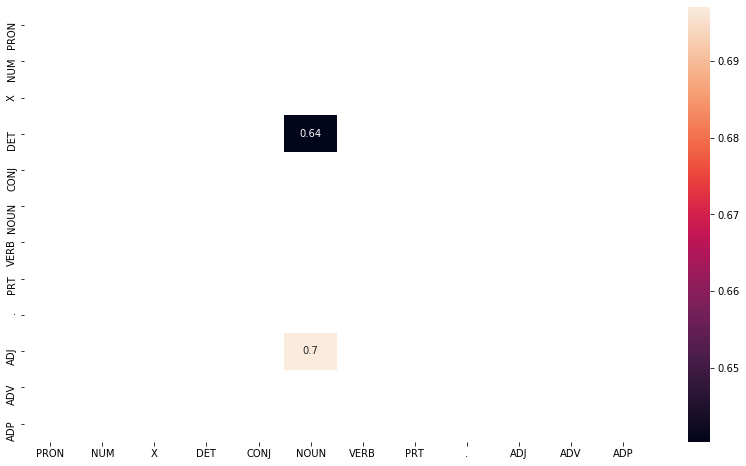

In [11]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5

tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(14, 8))
sns.heatmap(tags_frequent, annot = True)
plt.show()

<font color = "green"><h3><b> Build the vanilla Viterbi based POS tagger </b></h3></font>

In [12]:
# Viterbi Heuristic

def Vanilla_Viterbi(words, train_bag = train_set_tagged_words):
    
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    
    return list(zip(words, state))

In [13]:
random.seed(1234)

# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]


In [14]:
# tagging the test sentences

tagged_seq = Vanilla_Viterbi(test_tagged_words)

In [15]:
# Checking the accuracy of the vanilla viterbi algorithm

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

vanilla_viterbi_accuracy = len(check)/len(tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm is: ", vanilla_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm is:  0.9041903986981286


In [16]:
# Let's have a look at the incorrect tagged cases

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print("Total incorrect tags: ", len(incorrect_tagged_cases))
incorrect_tagged_cases

Total incorrect tags:  471


[[('.', '.'), (('Institutions', 'PRON'), ('Institutions', 'NOUN'))],
 [('the', 'DET'), (('sidelines', 'PRON'), ('sidelines', 'NOUN'))],
 [('a', 'DET'), (('spread', 'VERB'), ('spread', 'NOUN'))],
 [('%', 'NOUN'), (('bellwether', 'PRON'), ('bellwether', 'NOUN'))],
 [('of', 'ADP'), (('New', 'NOUN'), ('New', 'ADJ'))],
 [('New', 'ADJ'), (('York-based', 'NOUN'), ('York-based', 'ADJ'))],
 [('and', 'CONJ'), (('Broken', 'PRON'), ('Broken', 'NOUN'))],
 [('Hill', 'NOUN'), (('Pty.', 'PRON'), ('Pty.', 'NOUN'))],
 [('minimum', 'ADJ'), (('five-cent', 'PRON'), ('five-cent', 'ADJ'))],
 [('five-cent', 'ADJ'), (('change', 'VERB'), ('change', 'NOUN'))],
 [('have', 'VERB'), (('difficulty', 'PRON'), ('difficulty', 'NOUN'))],
 [('*-2', 'X'), (('shoring', 'PRON'), ('shoring', 'VERB'))],
 [('shoring', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [(',', '.'), (('U.S.-Japanese', 'PRON'), ('U.S.-Japanese', 'ADJ'))],
 [('economic', 'ADJ'), (('behemoth', 'PRON'), ('behemoth', 'NOUN'))],
 [('power', 'NOUN'), (('strugg

#### Before proceeding for dealing with unknown words, lets first see how many unknown words we have. 
#### Unknows words would be those words that are present in the test set but not in the train set. 
#### Those words the algorithm has not seen before.

In [17]:
# Unknown words 

test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - train_unique_words)
print("Total Unknown words: ", len(unknown_words))
print("\n")
print("Unknown Words: ", unknown_words)

Total Unknown words:  322


Unknown Words:  ['parlors', 'discrimination', 'impudent', 'propagandizes', 'disarray', 'resilient', 'TRUST', 'lifes', 'shivers', 'alarmed', 'U.S.S.R.', 'sacks', 'sidelines', 'IMSAI', 'highest-pitched', 'evaporated', 'repay', 'Mather', 'built-from-kit', 'adequately', 'Choose', 'fiber', '*T*-190', 'disagrees', 'ministry', 'intertitles', '62.625', '8.64', 'valuations', 'cotton', 'invests', 'beleaguered', 'garden-variety', 'families', 'committees', 'Hollis', 'rebounding', 'Dynamics', '5.82', 'midyear', '154.2', 'Earns', 'fan', 'Bowman', '*-134', 'unstinting', 'compel', 'voluntary', 'pricings', 'lesions', 'keyboards', 'duckling', '83,206', 'non-U.S.', 'draws', 'outraged', 'Huxtable', 'bellwether', 'Marder', 'negatives', 'sneaked', 'CERTIFICATES', 'bench', 'shudders', 'wrists', '3.01', 'onslaught', 'folio', '11,390,000', 'raspberry', 'laser', 'Environmental', '1.18', 'argues', 'standpoint', 'singled', 'unofficial', 'school-improvement', '576', 'RBC', 'chocolate', 


<font color = "green"><h3><b> Solve the problem of unknown words </b></h3></font>
<font color = "green"><h3><b> Method 1 </b></h3></font>


The default Vanilla viterbi algorithm achieved an accuracy of about 90.4%. This approx. 9% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

Now lets see how we can minimize this loss by modifying the vanilla viterbi.

If a word is not present in the training vocabulary (unknown word), its emission probability will be **ZERO**. In that case the state probability will inturn be zero. Thus in cases where the algorithm encounters a word which it has not see previously, we can omit the emission probability and only consider the transition probability.

The algorithm can be modified to deal the case as below - 



<font color = "brown"><h4><b> If word in unknown then: --> consider only the transition_p (emission probability being 0) </b></h4></font>
<font color = "brown"><h4><b> else: --> consider both the emission and transition probability.</b></h4></font>



In [18]:
# Modified Viterbi Heuristic
def Vanilla_Viterbi_for_Unknown_Words(words, train_bag = train_set_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in train_unique_words:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
        
    return list(zip(words, state))

In [19]:
# tagging the test sentences
unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(test_tagged_words)

# accuracy
unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]

optimized_viterbi_accuracy = len(unknown_word_check)/len(unknown_word_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is: ", optimized_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is - 0.9408055329536208


We see the modified viterbi algorithm **performs better** than the original vanilla viterbi algorithm. The modified viterbi achieves an accuracy of (approx.) **94.44%** comapred to **90.4%** of the vanilla viterbi.

Still there is a loss of approx. 6%. 

Now lets see if we can in reduce this loss further.

<font color = "green"><h3><b> Lexicon and Rule-Based Models for POS Tagging </b></h3></font>

<font color = "brown"><h3><b> Unigram Tagger </b></h3></font>


In [20]:
# Unigram Tagger

unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is: ", unigram_tagger_accuracy)

The accuracy of the Unigram Tagger is:  0.9023596419853539


In [21]:
# patterns for tagging using a rule based regex tagger -

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),      # Alpha Numeric
    (r'.*s$', 'NOUN'),                 # plural nouns
    (r'.*', 'NOUN'),                   # noun
    (r'.*\'s$', 'NOUN'),               # possessive nouns
    (r'.*ness$', 'NOUN'),
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # past tense, gerund, verb
    (r'.*ly$', 'ADV'),                 # adverb
    (r'^(0|([*|-|$].*))','X'),         # Any special character combination
    (r'.*ould$', 'X'),                 # modals
    (r'(The|the|A|a|An|an)$', 'DET'),  # determinant
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'),               # adjective like 100-megabytes 237-Seats
    (r'[0-9].?[,\/]?[0-9]*','NUM')     # Numbers 
    ]

In [23]:
# rule based RegexpTagger

rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

rule_based_unigram_tagger_accuracy = rule_based_unigram_tagger.evaluate(test_set)

print("Unigram Tagger backed up by the RegexpTagger accuracy: ", rule_based_unigram_tagger_accuracy)

Unigram Tagger backed up by the RegexpTagger accuracy:  0.9377542717656632


In [24]:
# Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)
bigram_tagger_accuracy = bigram_tagger.evaluate(test_set)
print("Bigram Tagger backed up by the rule_based_unigram_tagger accuracy: ", bigram_tagger_accuracy)

Bigram Tagger backed up by the rule_based_unigram_tagger accuracy:  0.9399918633034988


In [25]:
# trigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)
trigram_tagger_accuracy = trigram_tagger.evaluate(test_set)
print("Trigram Tagger backed up by the bigram_tagger accuracy: ", trigram_tagger_accuracy)

Trigram Tagger backed up by the bigram_tagger accuracy:  0.9391781936533767


<font color = "green"><h3><b> Method 2 </b></h3></font>

We see that the Trigram Tagger backed up by the bigram tagger gives an accuracy of about 94%. Let's now try to modify the viterbi algorithm to use this trigram tagger as a back-off. 

When the viterbi algorithm is not able to tag an unknown word, it uses the rule-based tagger.

In [26]:
# A trigram tagger backed off by a rule based tagger.

def custom_trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # past tense, gerun and verb

    (r'.*ly$', 'ADV'),                 # adverb
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),  # adjective
    (r'.*ful$', 'ADJ'),                # adjective
    (r'.*able$', 'ADJ'),               # adjective
    (r'.*ous$', 'ADJ'),                # adjective
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),             # noun
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ment$', 'NOUN'),             # noun
    (r'.*ers$', 'NOUN'),              # noun
    (r'.*town$', 'NOUN'),             # noun
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    
    return trigram_regex_tagger.tag_sents([[(word)]])

In [27]:
def viterbi_backedup_by_trigram_tagger(words, train_bag = train_set_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in train_unique_words:
            unknown_word_tag = custom_trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

<font color = "green"><h3><b> Evaluating tagging accuracy </b></h3></font>

In [28]:
# tagging the test sentences
viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(test_tagged_words)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)

print("Viterbi_backedup_by_trigram_tagger accuracy: ", viterbi_trigram_accuracy)

Viterbi_backedup_by_trigram_tagger accuracy:  0.9562652563059398


<font color = "green"><h3><b> Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm </b></h3></font>

<font color = "brown"><h3><b> 1. Checking accuracy on test_train_split treebank dataset</b></h3></font>

In [29]:
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], 
                  ['Optimized Vanilla Viterbi', optimized_viterbi_accuracy*100], 
                  ['Unigram Tagger', unigram_tagger_accuracy*100],
                  ['Unigram + RegexpTagger', rule_based_unigram_tagger_accuracy*100],
                  ['Bigram Tagger + Unigram_tagger', bigram_tagger_accuracy*100],
                  ['Trigram Tagger + Bigram_tagger', trigram_tagger_accuracy*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,90.419040
Optimized Vanilla Viterbi,94.080553
Unigram Tagger,90.235964
Unigram + RegexpTagger,93.775427
Bigram Tagger + Unigram_tagger,93.999186
Trigram Tagger + Bigram_tagger,93.917819
Viterbi + Trigram_tagger,95.626526


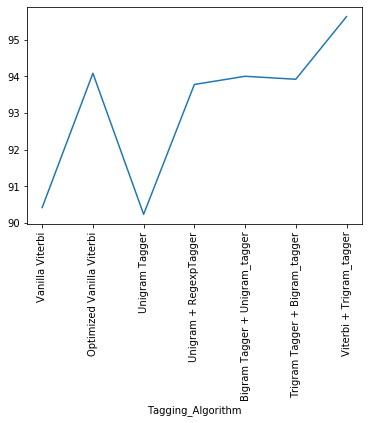

In [30]:
acccuracy_data_df.plot.line(rot = 90, legend = False)

<font color = "brown"><h3><b> 2.  Next, lets check the tagging accuracies for the algorithm on the sample test sentences provided </b></h3></font>

In [51]:
sample_test_sentences = []
test_file = open(test_file_path, 'r')

for line in test_file:
    sample_test_sentences.append(line)
test_file.close()


In [32]:
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [33]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]


# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]

In [34]:
sample_test_tagged_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

<font color = "green"><h3><b> 1. Testing the accuracy of Vanilla Viterbi on sample test data </b></h3></font>

In [35]:
# tagging the test sentences
sample_test_tagged_seq = Vanilla_Viterbi(sample_test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(sample_test_tagged_seq)

print("Vanilla Viterbi accuracy on the sample test data: ", vanilla_viterbi_accuracy_on_sample_test_data)

Vanilla Viterbi accuracy on the sample test data:  0.7513812154696132


<font color = "green"><h3><b> 2. Testing the accuracy of Vanilla_Viterbi_for_Unknown_Words on sample test data </b></h3></font>

In [36]:
# tagging the test sentences
sample_test_unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)

# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_optimized_viterbi_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("Vanilla_Viterbi_for_Unknown_Words accuracy on the sample test data:", sample_test_optimized_viterbi_accuracy)

Vanilla_Viterbi_for_Unknown_Words accuracy on the sample test data: 0.861878453038674


<font color = "green"><h3><b> 3. Testing the accuracy of viterbi_backedup_by_trigram_tagger on sample test data </b></h3></font>

In [37]:
# tagging the test sentences
sample_test_viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)

# accuracy
sample_test_viterbi_trigram_check = [i for i, j in zip(sample_test_viterbi_trigram_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_viterbi_trigram_accuracy = len(sample_test_viterbi_trigram_check)/len(sample_test_viterbi_trigram_tagged_seq)

print("Viterbi_backedup_by_trigram_tagger accuracy on the sample test data: ", sample_test_viterbi_trigram_accuracy)

Viterbi_backedup_by_trigram_tagger accuracy on the sample test data:  0.9281767955801105


<font color = "green"><h3><b> Comparing the accuracies of the 3 algorithm on sample test data </b></h3></font>

In [38]:
acccuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Optimized Vanilla Viterbi', sample_test_optimized_viterbi_accuracy*100], 
                  ['Viterbi + Trigram_tagger', sample_test_viterbi_trigram_accuracy*100]]

sample_test_data_acccuracy_df = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

sample_test_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

sample_test_data_acccuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,75.138122
Optimized Vanilla Viterbi,86.187845
Viterbi + Trigram_tagger,92.817680


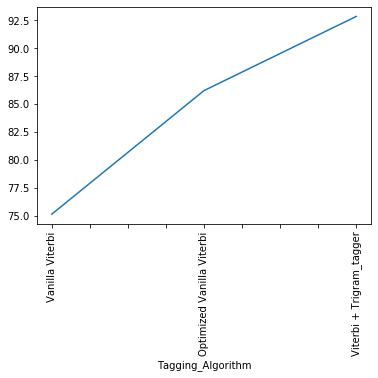

In [39]:
sample_test_data_acccuracy_df.plot.line(rot = 90, legend = False)

<font color = "green"><h3><b> List down cases which were incorrectly tagged by original POS tagger & got corrected by your modifications </b></h3></font>

In [56]:
# test sentences
    
test_sentence_1 = sample_test_sentences[0]
print(test_sentence_1)

Android is a mobile operating system developed by Google.



<font color = "green"><h3><b> Case - 1 </b></h3></font>

In [41]:
# test_sentence_1 = 'Android is a mobile operating system developed by Google.'

words_test_sentence_1 = nltk.word_tokenize(test_sentence_1)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(words_test_sentence_1)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('='*127)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(words_test_sentence_1)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'PRON'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRON'), ('.', '.')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [42]:
cols = ['vanilla_viterbi_tags', 'viterbi_trigram_tags_with_corrections']
tags_correction_df_1 = pd.DataFrame(columns = cols)
tags_correction_df_1 = tags_correction_df_1.fillna(0)

tags_correction_df_1.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi]
tags_correction_df_1.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram]

tags_correction_df_1

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Android, PRON)","(Android, NOUN)"
1,"(is, VERB)","(is, VERB)"
2,"(a, DET)","(a, DET)"
3,"(mobile, ADJ)","(mobile, ADJ)"
4,"(operating, NOUN)","(operating, NOUN)"
5,"(system, NOUN)","(system, NOUN)"
6,"(developed, VERB)","(developed, VERB)"
7,"(by, ADP)","(by, ADP)"
8,"(Google, PRON)","(Google, NOUN)"
9,"(., .)","(., .)"


#### As we see above in the sample test sentence 1 the word 'Android' was tagged as PRT by vanilla viterbi. The modified algorithm of viterbi backed up by trigram tagger corrected this and tagged 'Android' as NOUN.

<font color = "green"><h3><b> Case - 2 </b></h3></font>

In [43]:
# test_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, 
#                   an international football tournament contested once every four years.'

words_test_sentence_6 = nltk.word_tokenize(test_sentence_6)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_6 = Vanilla_Viterbi(words_test_sentence_6)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi_6)

print('\n')
print('-'*120)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_6 = viterbi_backedup_by_trigram_tagger(words_test_sentence_6)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_6)

Tagging sequence with Vanilla_Viterbi -

 [('The', 'DET'), ('2018', 'PRON'), ('FIFA', 'PRON'), ('World', 'NOUN'), ('Cup', 'PRON'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'PRON'), ('FIFA', 'PRON'), ('World', 'NOUN'), ('Cup', 'PRON'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'PRON'), ('contested', 'PRON'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', '

In [44]:
tags_correction_df_6 = pd.DataFrame(columns = cols)
tags_correction_df_6 = tags_correction_df_6.fillna(0)

tags_correction_df_6.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_6]
tags_correction_df_6.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_6]

tags_correction_df_6

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(The, DET)","(The, DET)"
1,"(2018, PRON)","(2018, NUM)"
2,"(FIFA, PRON)","(FIFA, NOUN)"
3,"(World, NOUN)","(World, NOUN)"
4,"(Cup, PRON)","(Cup, NOUN)"
5,"(is, VERB)","(is, VERB)"
6,"(the, DET)","(the, DET)"
7,"(21st, PRON)","(21st, NUM)"
8,"(FIFA, PRON)","(FIFA, NOUN)"
9,"(World, NOUN)","(World, NOUN)"


#### As we see above in the sample test sentence 6 the following words were incorrectly tagged by the vanilla viterbi algorithm -  '2018' - PRT, 'FIFA' - PRT, 'Cup' - PRT, '21st' - PRT, 'tournament' - PRT, 'contested' - PRT.

#### The above words were corrected by viterbi backed up by the trigram tagger. The corrections were made as - '2018' - NUM, 'FIFA' - NOUN, 'Cup' - NOUN, '21st' - NUM, 'tournament' - NOUN, 'contested' - VERB.


<font color = "green"><h3><b> Case - 3 </b></h3></font>

In [45]:
# test_sentence_8 = 'Show me the cheapest round trips from Dallas to Atlanta'

words_test_sentence_8 = nltk.word_tokenize(test_sentence_8)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_8 = Vanilla_Viterbi(words_test_sentence_8)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi_8)

print('\n')
print('-'*120)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_8 = viterbi_backedup_by_trigram_tagger(words_test_sentence_8)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_8)

Tagging sequence with Vanilla_Viterbi -

 [('Show', 'PRON'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'PRON'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'NOUN'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]


In [46]:
tags_correction_df_8 = pd.DataFrame(columns = cols)
tags_correction_df_8 = tags_correction_df_8.fillna(0)

tags_correction_df_8.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_8]
tags_correction_df_8.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_8]

tags_correction_df_8

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Show, PRON)","(Show, NOUN)"
1,"(me, PRON)","(me, PRON)"
2,"(the, DET)","(the, DET)"
3,"(cheapest, ADJ)","(cheapest, ADJ)"
4,"(round, NOUN)","(round, NOUN)"
5,"(trips, PRON)","(trips, NOUN)"
6,"(from, ADP)","(from, ADP)"
7,"(Dallas, NOUN)","(Dallas, NOUN)"
8,"(to, PRT)","(to, PRT)"
9,"(Atlanta, NOUN)","(Atlanta, NOUN)"


#### As we see in the sample test sentence 8, the vanilla viterbi tagged 'trips' as PRT. This was corrected by the modified viterbi algorithm (backed up by the trigram tagger) and tagged as NOUN.
#### Now lets see the tags and corrections for all the sample test sentences with both the methods.

#### Method 1 - We used only the transition probability for unknown words.
#### Method 2 - We used the viterbi algorithm and backed it up with the trigram tagger which was inturn backed up by the rule based regex tagger.

In [47]:
# Default Vanilla Viterbi
# pos tags with Vanilla_Viterbi
sample_test_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(sample_test_tagged_words)
print("Tagging sequence with Vanilla_Viterbi -\n\n", sample_test_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*120)

# Method 1 - pos tags with Vanilla_Viterbi_for_Unknown_Words
sample_test_tagged_sequence_unknown_words = Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)
print("Tagging sequence with viterbi using only transition probability for unknown words -\n\n", 
      sample_test_tagged_sequence_unknown_words)

print('\n')
print('-'*120)

# Method 2 - pos tags with viterbi_backedup_by_trigram_tagger
sample_test_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", sample_test_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'PRON'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRON'), ('.', '.'), ('Android', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRON'), ('worldwide', 'PRON'), ('on', 'ADP'), ('smartphones', 'PRON'), ('since', 'ADP'), ('2011', 'PRON'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'PRON'), ('.', '.'), ('Google', 'PRON'), ('and', 'CONJ'), ('Twitter', 'PRON'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRON'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'PRON'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'PRON'), ("'s", 'VERB'), ('firehose', 'PRON'), ('.', '.'), ('Twitter', 'PRON'), ('is', 'VERB'), ('an', 'DET'), ('online', 'PRON'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service

In [48]:
# A dataframe showing - 
# 1. the actual tags using nltk.pos_tag_sent
# 2. words as tagged by vanilla viterbi
# 3. words as tagged by Vanilla_Viterbi_for_Unknown_Words - METHOD - 1
# 4. words as tagged by viterbi_backedup_by_trigram_tagger - METHOD - 2

cols1 = ['actual_tags', 'as_tagged_by_vanilla_viterbi', 'as_tagged_by_Vanilla_Viterbi_for_Unknown_Words',
            'as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger']

tags_comparison_df = pd.DataFrame(columns = cols1)
tags_comparison_df = tags_comparison_df.fillna(0)

# Actual tags
tags_comparison_df.actual_tags = [tup for tup in sample_test_test_run_base]

# tags by vanilla viterbi
tags_comparison_df.as_tagged_by_vanilla_viterbi = [tup for tup in sample_test_tagged_sequence_with_vanilla_viterbi]

# tags by Vanilla_Viterbi_for_Unknown_Words - METHOD - 1
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_for_Unknown_Words = [tup for tup in sample_test_tagged_sequence_unknown_words]

# tags by viterbi_backedup_by_trigram_tagger - METHOD - 2
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger = [tup for tup in 
                                                                            sample_test_tagged_sequence_with_viterbi_trigram]

tags_comparison_df[tags_comparison_df.as_tagged_by_vanilla_viterbi != 
                   tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger]

,actual_tags,as_tagged_by_vanilla_viterbi,as_tagged_by_Vanilla_Viterbi_for_Unknown_Words,as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger
0,"(Android, NOUN)","(Android, PRON)","(Android, NOUN)","(Android, NOUN)"
8,"(Google, NOUN)","(Google, PRON)","(Google, DET)","(Google, NOUN)"
10,"(Android, NOUN)","(Android, PRON)","(Android, NOUN)","(Android, NOUN)"
15,"(OS, NOUN)","(OS, PRON)","(OS, NOUN)","(OS, NOUN)"
16,"(worldwide, NOUN)","(worldwide, PRON)","(worldwide, NOUN)","(worldwide, NOUN)"
18,"(smartphones, NOUN)","(smartphones, PRON)","(smartphones, DET)","(smartphones, VERB)"
20,"(2011, NUM)","(2011, PRON)","(2011, DET)","(2011, NUM)"
25,"(2013, NUM)","(2013, PRON)","(2013, DET)","(2013, NUM)"
27,"(Google, NOUN)","(Google, PRON)","(Google, NOUN)","(Google, NOUN)"
29,"(Twitter, NOUN)","(Twitter, PRON)","(Twitter, NOUN)","(Twitter, NOUN)"


# Conclusion - 

#### Thus we see that most of the words that were incorrectly tagged by the vanilla viterbi algorithm were corrected by the viterbi algorithm backed up by the trigram tagger. 

**In this analysis we used 2 modification techniques for the original vanilla viterbi -**

#### Method 1 - 
    - We used only the transition probability for unknown words.
    - This method showed an increase in the accuracy (94.4%) but still had some incorrect classification.
    
    - The accuracy could be increased further and we turned two a second modification in method-2 below.
    
#### Method 2 - 
    - We used the viterbi algorithm and backed it up with the trigram tagger which was inturn backed up by the rule based 
    regex tagger.
    - This gave us an accuracy of 95.82% on the test data.
    - Also on testing this model on the provided sample test data, it achieved an accuracy of 92.81% and comes out to be 
    the winner.

In [1]:
inv_type = 'Test'

In [2]:
print(f"Ideal investment type for Spark Funds is: {inv_type}")

Ideal investment type for Spark Funds is: Test
